In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load synthetic grid data
bouguer_anomaly_data = pd.read_csv("/content/syntheticgrav_CO.csv")

# Define the scenario at the beginning of the code
scenario = "transition"  # Options: "transition" or "unique"

# Extract coordinates and values
x_coords = bouguer_anomaly_data['X'].values
y_coords = bouguer_anomaly_data['Y'].values
bouguer_anomaly = bouguer_anomaly_data['Bouguer'].values

# Define resolution and create grid
resolution = 80  # put in meters (Ex.: 4000m = 4km)
grid_x, grid_y = np.arange(x_coords.min(), x_coords.max(), resolution), \
                 np.arange(y_coords.min(), y_coords.max(), resolution)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Interpolate Bouguer anomaly grid
bouguer_anomaly_grid = griddata(
    (x_coords, y_coords),
    bouguer_anomaly,
    (grid_x, grid_y),
    method='cubic'
)

# Handle NaNs in the grid
if np.isnan(bouguer_anomaly_grid).any():
    mean_value = np.nanmean(bouguer_anomaly_grid)
    bouguer_anomaly_grid = np.nan_to_num(bouguer_anomaly_grid, nan=mean_value)

print("Bouguer anomaly grid created:", bouguer_anomaly_grid.shape)


Bouguer anomaly grid created: (10, 10)


In [ ]:
# Temperature calculation function
def calculate_temperature(depth, anomaly, scenario=scenario):
    T_surface = 0  # Surface temperature in °C
    k = 3.5  # Thermal conductivity (W/m/K)

    # Adjust heat flow based on the scenario and anomaly
    if scenario == "transition":  # Continent-ocean transition
        q_0_continent = 60  # Heat flow in the continent (mW/m²)
        q_0_ocean = 90  # Heat flow in the ocean (mW/m²)
        q_0 = q_0_continent + (q_0_ocean - q_0_continent) * (anomaly / 100)
    else:  # Single environment with multiple ranges
        q_0_low = 30  # Lower heat flow range (mW/m²)
        q_0_medium = 55  # Medium heat flow range (mW/m²)
        q_0_high = 90  # Upper heat flow range (mW/m²)

        # Adjust q_0 based on the anomaly
        q_0 = np.where(anomaly < -80, q_0_low,
                       np.where((anomaly >= 0) & (anomaly < 60), q_0_medium,
                                q_0_high))

    # Calculate temperature for each grid point
    T_fourier = T_surface + (q_0 * depth / k) + (anomaly * 1e-5)

    # Limit temperatures between 0°C and 1300°C
    T_fourier = np.minimum(T_fourier, 1300)  # Upper limit
    T_fourier = np.maximum(T_fourier, 0)     # Lower limit

    return T_fourier

# Define depths and prepare temperature grid
depths = np.linspace(0, 300, 100)  # Depths from 0 to 300 km
temperature_grid = np.zeros((len(depths), grid_x.shape[0], grid_y.shape[1]))

# Calculate temperature for each depth and grid point
for i, depth in enumerate(depths):
    temperature_layer = calculate_temperature(depth, bouguer_anomaly_grid)
    temperature_grid[i, :, :] = temperature_layer

    if np.all(temperature_layer >= 1300):
        print(f"1300°C limit reached at depth {depth} km.")
        break

# Verify temperatures within limits
min_temp = np.min(temperature_grid)
max_temp = np.max(temperature_grid)

print(f"Minimum grid temperature: {min_temp}°C")
print(f"Maximum grid temperature: {max_temp}°C")

if min_temp >= 0 and max_temp <= 1300:
    print("All temperatures are within expected limits (0°C to 1300°C).")
else:
    print("Some temperatures are outside the limits!")

# Replace NaNs and infinities in the temperature grid
temperature_grid[np.isnan(temperature_grid)] = 0
temperature_grid[np.isinf(temperature_grid)] = 0

# Define target isotherms
isotherms = np.arange(100, 1400, 100)
isotherm_grids = {iso: np.full((grid_x.shape[0], grid_y.shape[1]), np.nan) for iso in isotherms}

# Populate isotherm grids with depths
for iso in isotherms:
    for i, depth in enumerate(depths):
        mask = (temperature_grid[i] >= iso) & np.isnan(isotherm_grids[iso])
        isotherm_grids[iso][mask] = depth


1300°C limit reached at depth 133.33333333333334 km.
Minimum grid temperature: 0.0°C
Maximum grid temperature: 1300.0°C
All temperatures are within expected limits (0°C to 1300°C).


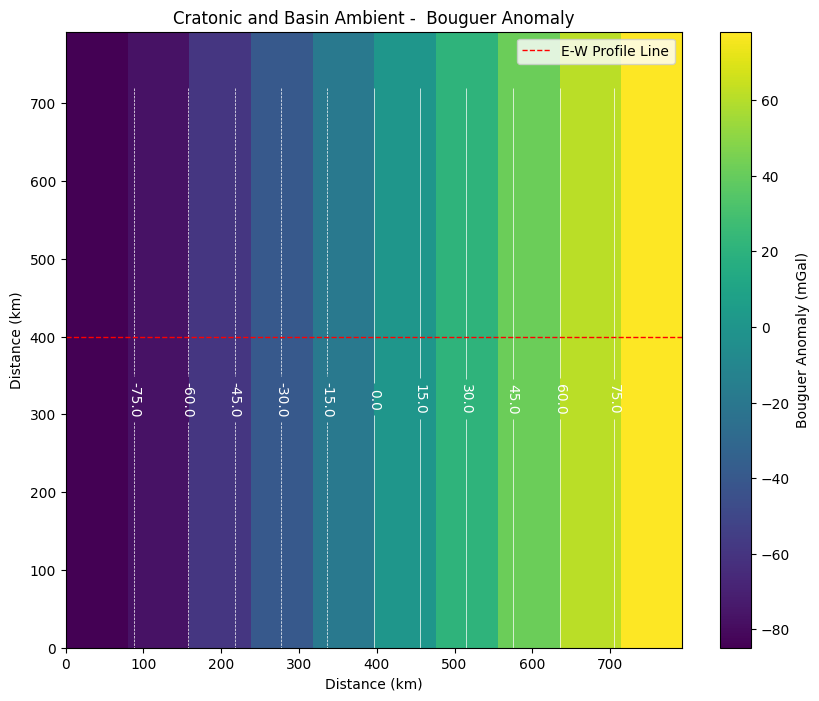

In [ ]:
# Plot Bouguer Anomaly with contour lines in a separate figure
plt.figure(figsize=(10, 8))
img = plt.imshow(bouguer_anomaly_grid, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                 origin='lower', cmap='viridis')
contours = plt.contour(grid_x, grid_y, bouguer_anomaly_grid, levels=15, colors='white', linewidths=0.5)
plt.clabel(contours, inline=True, fontsize=10, fmt='%1.1f', colors='white')  # Set color for contour labels

# Colorbar settings
cbar = plt.colorbar(img)
cbar.set_label('Bouguer Anomaly (mGal)', color='black', fontsize=10)  # Set label color and font size
cbar.ax.yaxis.set_tick_params(color='black')  # Set tick color
plt.setp(cbar.ax.get_yticklabels(), color='black')  # Set tick labels color

# Draw E-W line at Y = 400 to indicate profile position
plt.axhline(y=400, color='red', linestyle='--', linewidth=1, label='E-W Profile Line')

# Add legend for the E-W line
plt.legend()

plt.title('Cratonic and Basin Ambient -  Bouguer Anomaly')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.show()

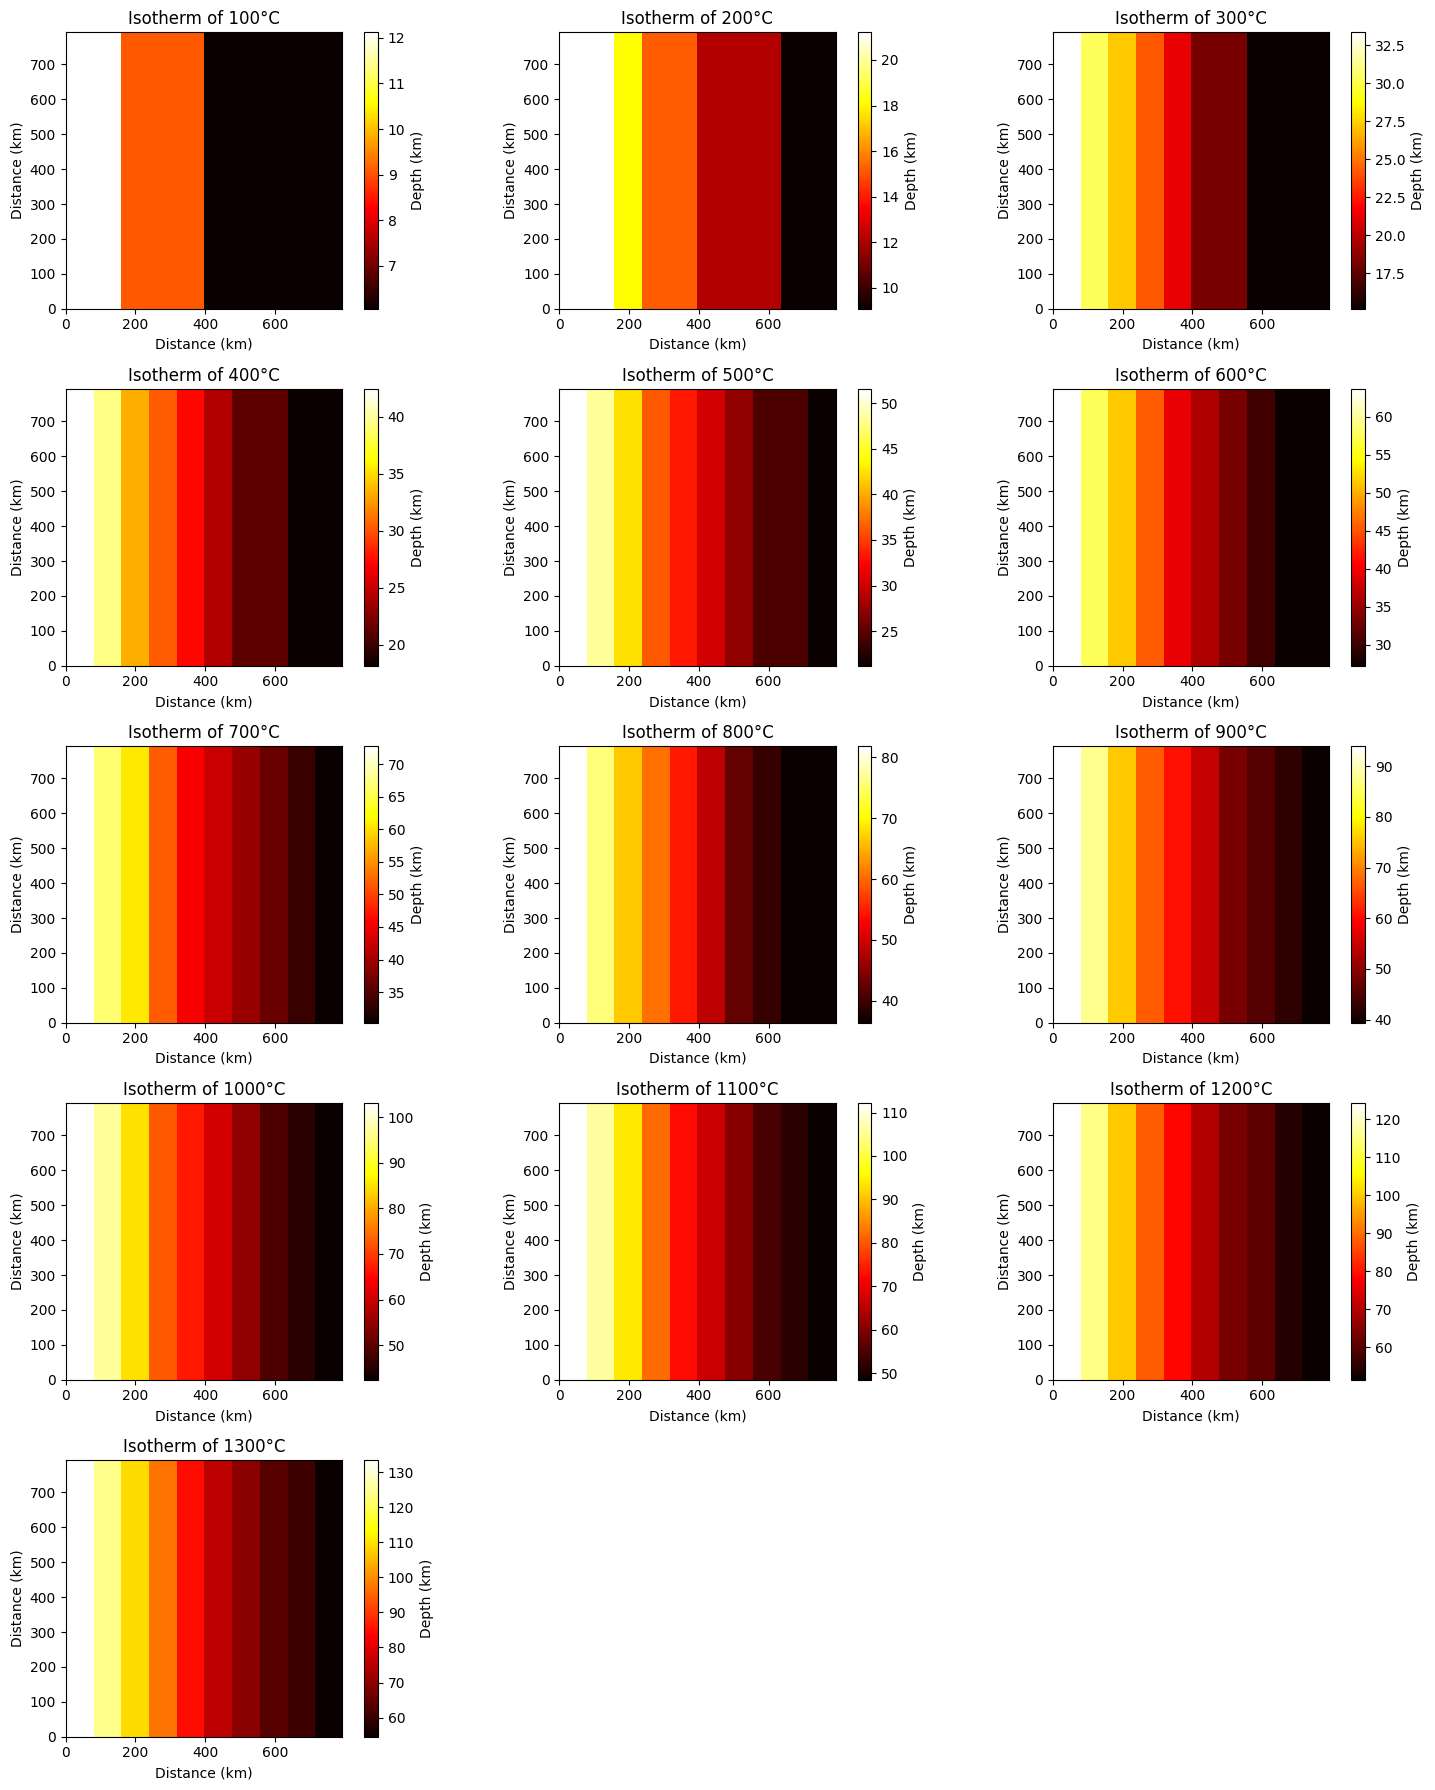

In [ ]:
# Plot Isotherms in a separate figure with subplots
plt.figure(figsize=(15, 18))

# Isotherm subplots
for i, iso in enumerate(isotherms, start=1):  # Start at 1 since it's a new figure
    plt.subplot(5, 3, i)
    plt.imshow(isotherm_grids[iso], extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
               origin='lower', cmap='hot')
    plt.colorbar(label='Depth (km)')
    plt.title(f'Isotherm of {iso}°C')
    plt.xlabel('Distance (km)')
    plt.ylabel('Distance (km)')

plt.tight_layout()
plt.show()

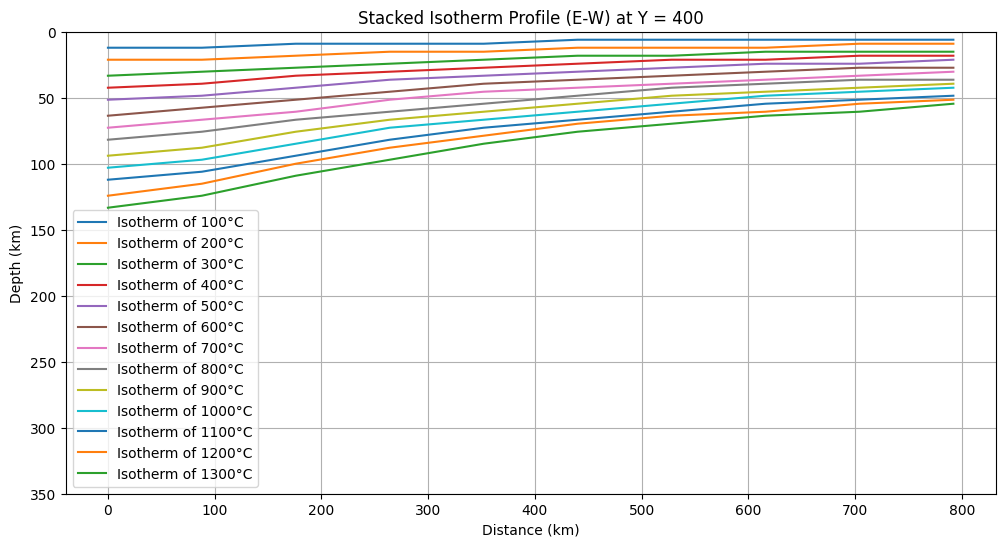

In [ ]:
# Find the closest index to Y = define in the grid_y array
y_target = 400
central_line = np.abs(grid_y[:, 0] - y_target).argmin()  # Index of the closest Y value to 400

# Extract the E-W profile for each isotherm at the specified Y position
mean_profiles = {iso: isotherm_grids[iso][central_line, :] for iso in isotherms}

# Create X-axis (E-W distance along the grid)
x_values = np.linspace(x_coords.min(), x_coords.max(), grid_x.shape[1])

# Plot the stacked isotherm profile (E-W)
plt.figure(figsize=(12, 6))

for iso, profile in mean_profiles.items():
    plt.plot(x_values, profile, label=f'Isotherm of {iso}°C')

# Adjust Y-axis for increasing depth
plt.gca().invert_yaxis()  # Invert Y-axis to show greater depth downward
plt.ylim(350, 0)  # Limit depth on the plot

# Add title and labels
plt.title(f'Stacked Isotherm Profile (E-W) at Y = {y_target}')
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')
plt.legend()
plt.grid(True)
plt.show()


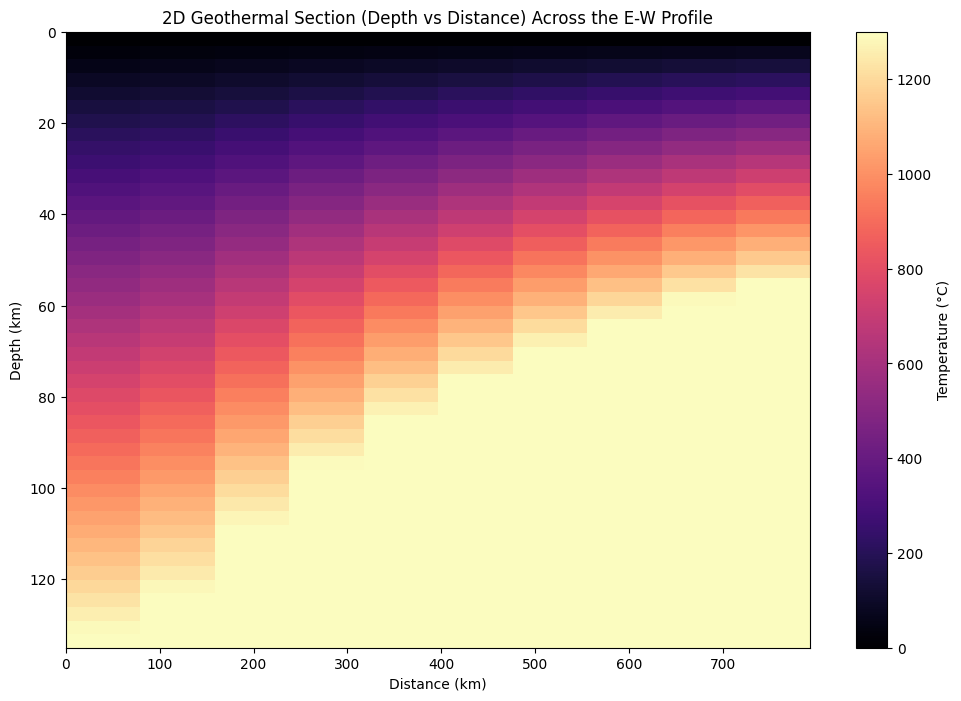

In [ ]:
# Initialize the array for the 2D section with depth vs temperature along the E-W profile
geothermal_section_2D = np.zeros((len(depths), grid_x.shape[1]))

# Fill the array with temperatures along the E-W profile for each depth
for i, depth in enumerate(depths):
    geothermal_section_2D[i, :] = temperature_grid[i, central_line, :]

# Create X-axis (distance along the E-W profile) and Y-axis (depth)
x_values = np.linspace(x_coords.min(), x_coords.max(), grid_x.shape[1])

# Plot the 2D geothermal section (Depth vs Distance)
plt.figure(figsize=(12, 8))
plt.imshow(
    geothermal_section_2D,
    extent=[x_values.min(), x_values.max(), depths.max(), depths.min()],
    aspect='auto',
    cmap='magma'
)
plt.colorbar(label='Temperature (°C)')
plt.title('2D Geothermal Section (Depth vs Distance) Across the E-W Profile')
plt.ylim(0, 135)  # Limit depth on the plot
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()  # Invert Y-axis to show increasing depth downward
plt.show()
